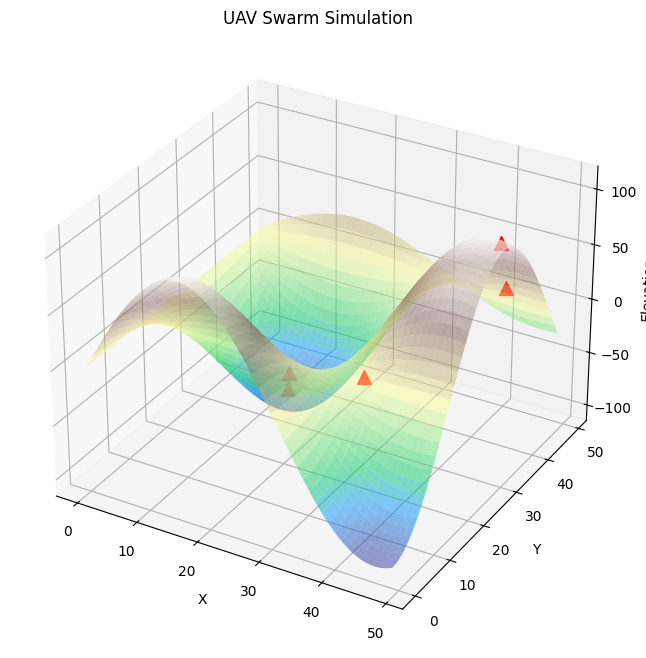

In [2]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple

@dataclass
class UAV:
    position: np.ndarray  # [x, y, z]
    velocity: np.ndarray  # [vx, vy, vz]
    battery: float        # remaining battery percentage
    id: int              # unique identifier

class TerrainMap:
    def __init__(self, size: Tuple[int, int], resolution: float = 1.0):
        self.size = size
        self.resolution = resolution
        self.elevation = np.zeros(size)
        
    def generate_sample_terrain(self):
        """Generate a sample terrain with hills and valleys"""
        x = np.linspace(0, 5, self.size[0])
        y = np.linspace(0, 5, self.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Create some hills and valleys
        self.elevation = 100 * np.sin(X) * np.cos(Y)
        
    def get_elevation(self, x: int, y: int) -> float:
        """Get elevation at specific coordinates"""
        if 0 <= x < self.size[0] and 0 <= y < self.size[1]:
            return self.elevation[y, x]
        return 0.0

class SwarmSimulation:
    def __init__(self, num_uavs: int, terrain: TerrainMap):
        self.terrain = terrain
        self.uavs = []
        self.initialize_swarm(num_uavs)
        
    def initialize_swarm(self, num_uavs: int):
        """Initialize UAV swarm with random positions"""
        for i in range(num_uavs):
            x = np.random.randint(0, self.terrain.size[0])
            y = np.random.randint(0, self.terrain.size[1])
            z = self.terrain.get_elevation(x, y) + 10  # 10m above terrain
            
            self.uavs.append(UAV(
                position=np.array([x, y, z]),
                velocity=np.zeros(3),
                battery=100.0,
                id=i
            ))
    
    def update(self, dt: float = 0.1):
        """Update simulation by one timestep"""
        for uav in self.uavs:
            # Simple update - just decrease battery
            uav.battery -= dt
            
            # Here you'll later add your ACO/BCO logic for path planning
            pass
    
    def visualize(self):
        """Visualize terrain and UAV positions"""
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot terrain
        x = np.arange(self.terrain.size[0])
        y = np.arange(self.terrain.size[1])
        X, Y = np.meshgrid(x, y)
        ax.plot_surface(X, Y, self.terrain.elevation, cmap='terrain', alpha=0.5)
        
        # Plot UAVs
        for uav in self.uavs:
            ax.scatter(uav.position[0], uav.position[1], uav.position[2], 
                      color='red', marker='^', s=100)
            
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        plt.title('UAV Swarm Simulation')
        plt.show()

# Example usage
def main():
    # Create terrain
    terrain = TerrainMap(size=(50, 50))
    terrain.generate_sample_terrain()
    
    # Create simulation with 5 UAVs
    sim = SwarmSimulation(num_uavs=5, terrain=terrain)
    
    # Run a few timesteps
    for _ in range(10):
        sim.update()
    
    # Visualize
    sim.visualize()

if __name__ == "__main__":
    main()

In [3]:
pip install numpy matplotlib scipy rasterio requests

Note: you may need to restart the kernel to use updated packages.


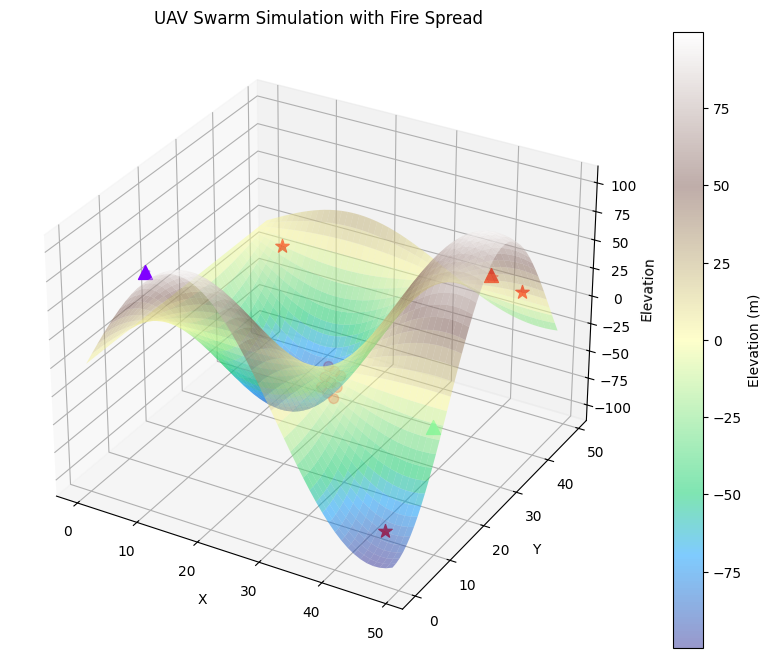

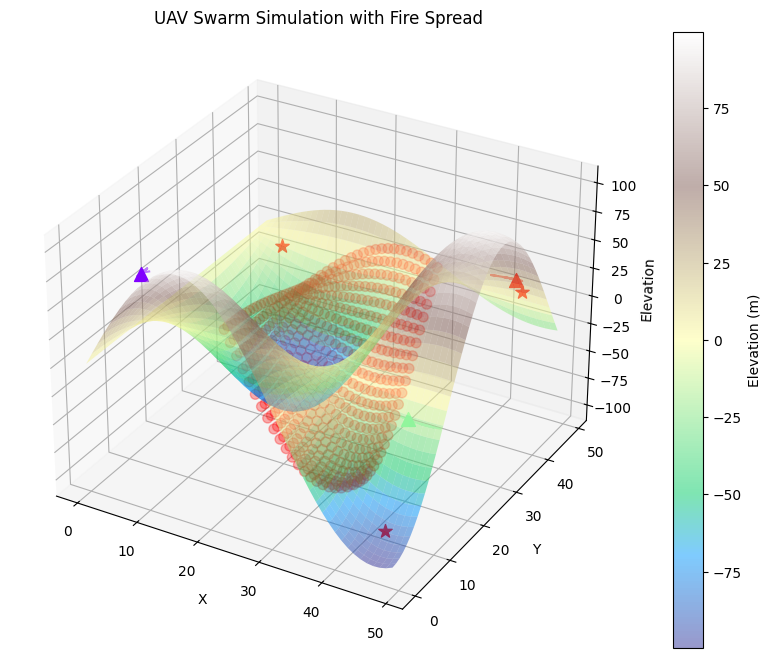

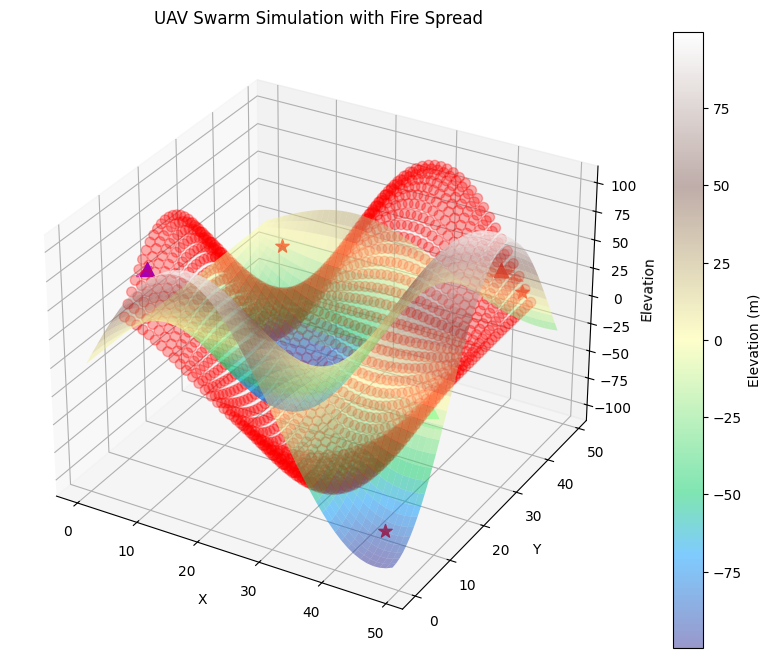

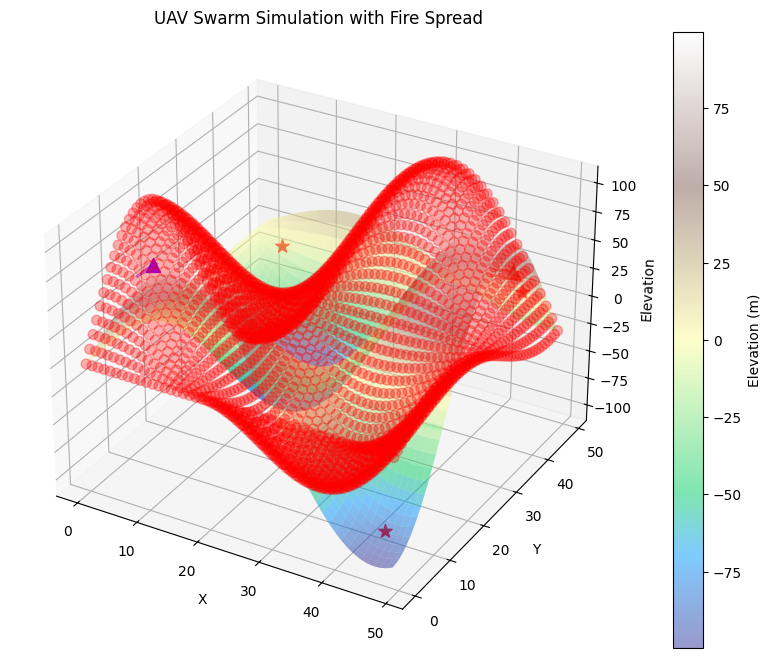

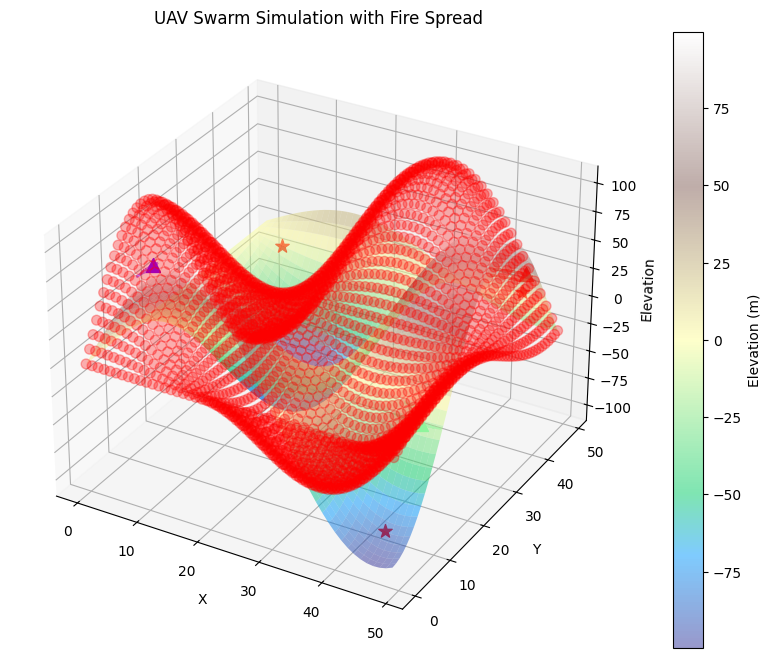

In [4]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple
import requests
import rasterio
from scipy.spatial import distance
import random

@dataclass
class UAV:
    position: np.ndarray
    velocity: np.ndarray
    battery: float
    id: int
    path: List[np.ndarray] = None
    
    def __post_init__(self):
        if self.path is None:
            self.path = [self.position]

class TerrainMap:
    def __init__(self, size: Tuple[int, int], resolution: float = 1.0):
        self.size = size
        self.resolution = resolution
        self.elevation = np.zeros(size)
        self.fire_map = np.zeros(size)  # Add fire map
        self.wind = np.array([1.0, 1.0])  # Add wind vector (direction and speed)
        
    def generate_sample_terrain(self):
        """Generate a sample terrain with hills and valleys"""
        x = np.linspace(0, 5, self.size[0])
        y = np.linspace(0, 5, self.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Create some hills and valleys
        self.elevation = 100 * np.sin(X) * np.cos(Y)
    
    def get_elevation(self, x: int, y: int) -> float:
        """Get elevation at specific coordinates"""
        if 0 <= x < self.size[0] and 0 <= y < self.size[1]:
            return self.elevation[y, x]  # Note: elevation array is indexed as [y,x]
        return 0.0
        
    def start_fire(self, position: Tuple[int, int], intensity: float = 1.0):
        """Start a fire at given position"""
        self.fire_map[position] = intensity
        
    def update_fire_spread(self, dt: float = 0.1):
        """Update fire spread based on wind, slope, and current fire state"""
        new_fire_map = self.fire_map.copy()
        
        for i in range(1, self.size[0]-1):
            for j in range(1, self.size[1]-1):
                if self.fire_map[i, j] > 0:
                    # Factor in wind direction
                    wind_factor = 1 + 0.1 * (
                        self.wind[0] * (self.fire_map[i+1, j] - self.fire_map[i-1, j]) +
                        self.wind[1] * (self.fire_map[i, j+1] - self.fire_map[i, j-1])
                    )
                    
                    # Factor in slope
                    slope = self.get_slope(i, j)
                    slope_factor = 1 + 0.05 * slope
                    
                    # Spread to neighbors
                    spread_rate = dt * wind_factor * slope_factor
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            if di == 0 and dj == 0:
                                continue
                            new_fire_map[i+di, j+dj] = max(
                                new_fire_map[i+di, j+dj],
                                self.fire_map[i, j] * spread_rate
                            )
        
        self.fire_map = new_fire_map
        self.fire_map = np.clip(self.fire_map, 0, 1)  # Normalize fire intensity

    def get_slope(self, x: int, y: int) -> float:
        """Calculate terrain slope at given position"""
        if 0 <= x < self.size[0]-1 and 0 <= y < self.size[1]-1:
            dx = self.elevation[y, x+1] - self.elevation[y, x]
            dy = self.elevation[y+1, x] - self.elevation[y, x]
            return np.sqrt(dx**2 + dy**2)
        return 0.0
    

class SwarmSimulation:
    def __init__(self, num_uavs: int, terrain: TerrainMap):
        self.terrain = terrain
        self.uavs = []
        self.aco = ACO(terrain)
        self.initialize_swarm(num_uavs)
        self.target_positions = []  # Will store target positions for each UAV
        
    def initialize_swarm(self, num_uavs: int):
        """Initialize UAV swarm with random positions"""
        for i in range(num_uavs):
            x = np.random.randint(0, self.terrain.size[0])
            y = np.random.randint(0, self.terrain.size[1])
            z = self.terrain.get_elevation(x, y) + 10  # 10m above terrain
            
            self.uavs.append(UAV(
                position=np.array([x, y, z]),
                velocity=np.zeros(3),
                battery=100.0,
                id=i
            ))
    
    def set_target_positions(self, targets: List[np.ndarray]):
        """Set target positions for UAVs"""
        self.target_positions = targets
        
    def update(self, dt: float = 0.1):
        """Update simulation by one timestep"""
        # Update fire spread
        self.terrain.update_fire_spread(dt)
        
        # Update UAV positions
        for i, uav in enumerate(self.uavs):
            if i < len(self.target_positions):
                current_pos = uav.position
                target_pos = self.target_positions[i]
                
                next_pos = self.aco.get_next_position(current_pos, target_pos)
                z = self.terrain.get_elevation(int(next_pos[0]), int(next_pos[1])) + 10
                
                uav.position = np.array([next_pos[0], next_pos[1], z])
                uav.path.append(uav.position)
                
                distance_moved = np.linalg.norm(next_pos - current_pos[:2])
                uav.battery -= dt * (1 + distance_moved)
    
    def visualize(self, show_paths: bool = True):
        """Enhanced visualization with fire"""
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot terrain
        x = np.arange(self.terrain.size[0])
        y = np.arange(self.terrain.size[1])
        X, Y = np.meshgrid(x, y)
        terrain_plot = ax.plot_surface(X, Y, self.terrain.elevation, 
                                     cmap='terrain', alpha=0.5)
        
        # Plot fire (red overlay where fire_map > 0)
        fire_positions = np.where(self.terrain.fire_map > 0)
        if len(fire_positions[0]) > 0:
            fire_z = self.terrain.elevation[fire_positions]
            ax.scatter(fire_positions[0], fire_positions[1], fire_z,
                      c='red', alpha=0.3, s=50)
        
        # Plot UAVs and paths
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.uavs)))
        for uav, color in zip(self.uavs, colors):
            ax.scatter(uav.position[0], uav.position[1], uav.position[2], 
                      color=color, marker='^', s=100)
            
            if show_paths and len(uav.path) > 1:
                path = np.array(uav.path)
                ax.plot(path[:, 0], path[:, 1], path[:, 2], 
                       color=color, alpha=0.5)
        
        # Plot targets
        for target in self.target_positions:
            ax.scatter(target[0], target[1], 
                      self.terrain.get_elevation(int(target[0]), int(target[1])),
                      color='red', marker='*', s=100)
        
        fig.colorbar(terrain_plot, ax=ax, label='Elevation (m)')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        plt.title('UAV Swarm Simulation with Fire Spread')
        plt.show()
        
        
def main():
    # Create terrain
    terrain = TerrainMap(size=(50, 50))
    terrain.generate_sample_terrain()
    
    # Start a fire
    terrain.start_fire((25, 25))  # Start fire in the middle
    
    # Create simulation with 3 UAVs
    sim = SwarmSimulation(num_uavs=3, terrain=terrain)
    
    # Set target positions
    targets = [
        np.array([45, 45]),
        np.array([45, 5]),
        np.array([5, 45])
    ]
    sim.set_target_positions(targets)
    
    # Run simulation
    for _ in range(50):
        sim.update()
        if _ % 10 == 0:  # Visualize every 10 steps
            sim.visualize()
            
class ACO:
    def __init__(self, terrain: TerrainMap, n_ants: int = 20, evaporation_rate: float = 0.1,
                 alpha: float = 1.0, beta: float = 2.0):
        self.terrain = terrain
        self.n_ants = n_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic importance
        self.pheromone = np.ones(terrain.size) * 0.1
        
    def _heuristic(self, current_pos: np.ndarray, next_pos: np.ndarray) -> float:
        """Calculate heuristic value based on elevation and distance"""
        dist = distance.euclidean(current_pos[:2], next_pos[:2])
        slope = abs(self.terrain.get_elevation(int(next_pos[0]), int(next_pos[1])) -
                   self.terrain.get_elevation(int(current_pos[0]), int(current_pos[1])))
        return 1.0 / (dist * (1 + slope))
    
    def get_next_position(self, current_pos: np.ndarray, target_pos: np.ndarray) -> np.ndarray:
        """Get next position using ACO"""
        possible_steps = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                new_x = int(current_pos[0] + dx)
                new_y = int(current_pos[1] + dy)
                
                if (0 <= new_x < self.terrain.size[0] and 
                    0 <= new_y < self.terrain.size[1]):
                    possible_steps.append(np.array([new_x, new_y]))
        
        if not possible_steps:
            return current_pos[:2]
        
        # Calculate probabilities
        probabilities = []
        for next_pos in possible_steps:
            pheromone = self.pheromone[int(next_pos[1]), int(next_pos[0])]
            heuristic = self._heuristic(current_pos, next_pos)
            probability = (pheromone ** self.alpha) * (heuristic ** self.beta)
            probabilities.append(probability)
        
        # Normalize probabilities
        probabilities = np.array(probabilities) / sum(probabilities)
        
        # Choose next position
        next_pos = possible_steps[np.random.choice(len(possible_steps), p=probabilities)]
        return next_pos

    def update_pheromone(self, paths: List[List[np.ndarray]], qualities: List[float]):
        """Update pheromone levels based on ant paths"""
        # Evaporation
        self.pheromone *= (1 - self.evaporation_rate)
        
        # Add new pheromone
        for path, quality in zip(paths, qualities):
            for pos in path:
                self.pheromone[int(pos[1]), int(pos[0])] += quality

if __name__ == "__main__":
    main()

Visualization saved to uav_swarm_visualization.png


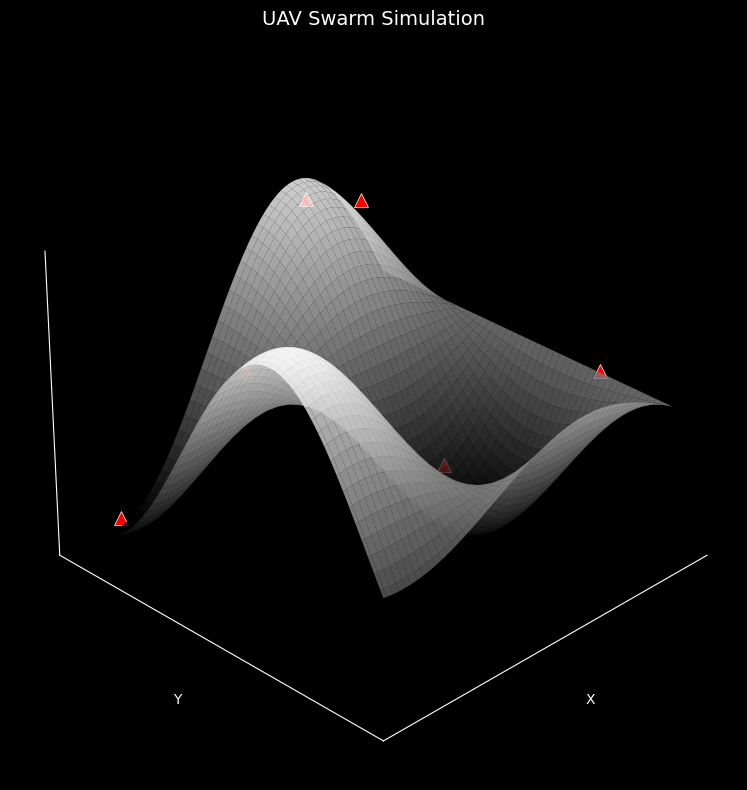

In [9]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple

@dataclass
class UAV:
    position: np.ndarray  # [x, y, z]
    velocity: np.ndarray  # [vx, vy, vz]
    battery: float        # remaining battery percentage
    id: int              # unique identifier

class TerrainMap:
    def __init__(self, size: Tuple[int, int], resolution: float = 1.0):
        self.size = size
        self.resolution = resolution
        self.elevation = np.zeros(size)
        
    def generate_sample_terrain(self):
        """Generate a sample terrain with hills and valleys"""
        x = np.linspace(0, 5, self.size[0])
        y = np.linspace(0, 5, self.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Create some hills and valleys
        self.elevation = 80 * np.sin(X) * np.cos(Y)
        
    def get_elevation(self, x: int, y: int) -> float:
        """Get elevation at specific coordinates"""
        if 0 <= x < self.size[0] and 0 <= y < self.size[1]:
            return self.elevation[y, x]
        return 0.0

class SwarmSimulation:
    def __init__(self, num_uavs: int, terrain: TerrainMap):
        self.terrain = terrain
        self.uavs = []
        self.initialize_swarm(num_uavs)
        
    def initialize_swarm(self, num_uavs: int):
        """Initialize UAV swarm with random positions"""
        for i in range(num_uavs):
            x = np.random.randint(0, self.terrain.size[0])
            y = np.random.randint(0, self.terrain.size[1])
            z = self.terrain.get_elevation(x, y) + 10  # 10m above terrain
            
            self.uavs.append(UAV(
                position=np.array([x, y, z]),
                velocity=np.zeros(3),
                battery=100.0,
                id=i
            ))
    
    def update(self, dt: float = 0.1):
        """Update simulation by one timestep"""
        for uav in self.uavs:
            # Simple update - just decrease battery
            uav.battery -= dt
            
            # Here you'll later add your ACO/BCO logic for path planning
            pass
    
    def visualize(self, save_path=None):
        """Visualize terrain and UAV positions with improved styling"""
        # Create figure with dark background
        plt.style.use('dark_background')
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot terrain in grayscale
        x = np.arange(self.terrain.size[0])
        y = np.arange(self.terrain.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Use grayscale colormap
        terrain_surface = ax.plot_surface(X, Y, self.terrain.elevation, 
                                        cmap='gray', alpha=0.8, 
                                        antialiased=True, shade=True)
        
        # Plot UAVs with red markers
        for uav in self.uavs:
            ax.scatter(uav.position[0], uav.position[1], uav.position[2], 
                      color='red', marker='^', s=100, 
                      edgecolor='white', linewidth=0.5)
        
        # Remove grid lines and numerical ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        # Set solid background color for panes
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        # Make pane edges invisible
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        # Keep minimal label text in white
        ax.set_xlabel('X', color='white', labelpad=10)
        ax.set_ylabel('Y', color='white', labelpad=10)
        ax.set_zlabel('Elevation', color='white', labelpad=10)
        
        # Set title with styling
        plt.title('UAV Swarm Simulation', color='white', fontsize=14, pad=20)
        
        # Improve camera angle
        ax.view_init(elev=30, azim=45)
        
        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
            print(f"Visualization saved to {save_path}")
            
        plt.tight_layout()
        plt.show()

# Example usage
def main():
    # Create terrain with higher resolution for better visualization
    terrain = TerrainMap(size=(100, 100))
    terrain.generate_sample_terrain()
    
    # Create simulation with more UAVs
    sim = SwarmSimulation(num_uavs=8, terrain=terrain)
    
    # Run a few timesteps
    for _ in range(10):
        sim.update()
    
    # Visualize
    sim.visualize(save_path="uav_swarm_visualization.png")

if __name__ == "__main__":
    main()

In [2]:
def add_drone_paths(self, ax):
    """Add visualization of drone paths"""
    # Example paths - replace with your actual path data
    for uav in self.uavs:
        # Generate a simple path for demonstration
        path_length = 20
        x_path = np.linspace(uav.position[0], uav.position[0] + np.random.randint(-15, 15), path_length)
        y_path = np.linspace(uav.position[1], uav.position[1] + np.random.randint(-15, 15), path_length)
        z_path = np.array([self.terrain.get_elevation(int(x), int(y)) + 10 for x, y in zip(x_path, y_path)])
        
        # Plot the path with a gradient color
        for i in range(path_length-1):
            alpha = 0.7 * (1 - i/path_length)  # Fade out older parts of the path
            ax.plot(x_path[i:i+2], y_path[i:i+2], z_path[i:i+2], 
                   color='red', alpha=alpha, linewidth=1)

Visualization saved to uav_swarm_white_background.png


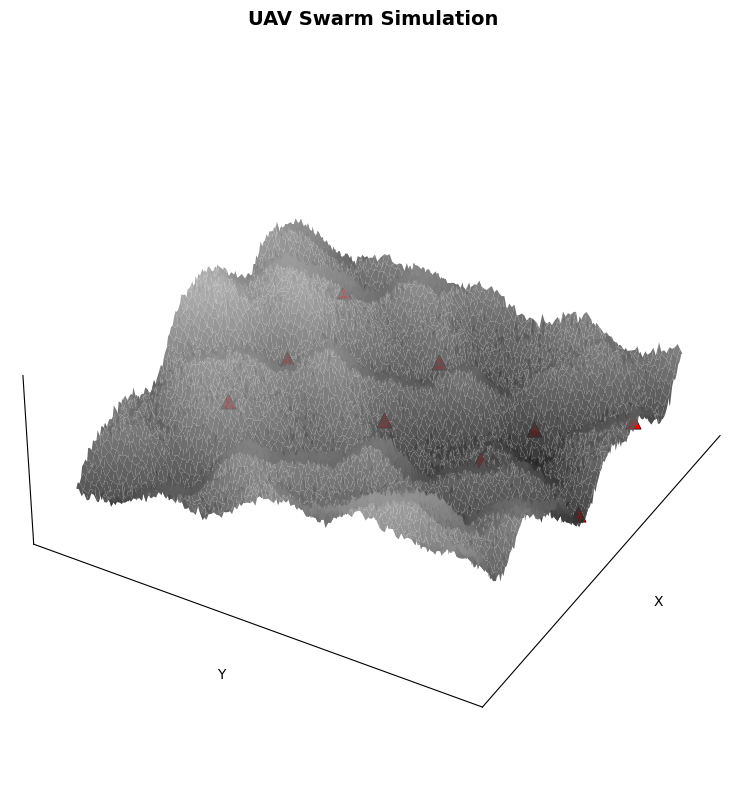

Visualization saved to uav_swarm_with_paths.png


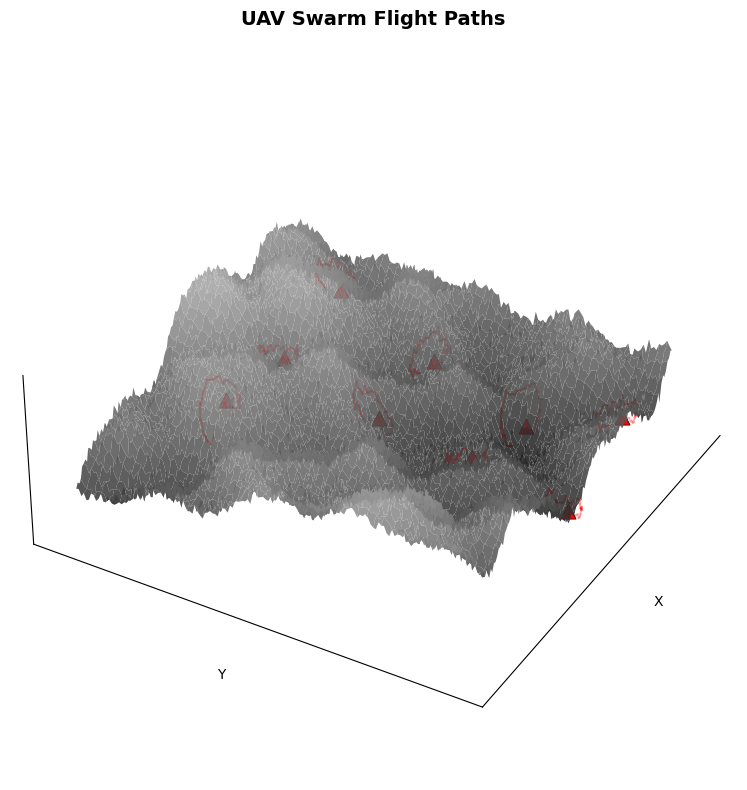

In [10]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple
import matplotlib as mpl

@dataclass
class UAV:
    position: np.ndarray  # [x, y, z]
    velocity: np.ndarray  # [vx, vy, vz]
    battery: float        # remaining battery percentage
    id: int              # unique identifier

class TerrainMap:
    def __init__(self, size: Tuple[int, int], resolution: float = 1.0):
        self.size = size
        self.resolution = resolution
        self.elevation = np.zeros(size)
        
    def generate_sample_terrain(self, seed=None):
        """Generate a more interesting terrain with hills and valleys"""
        if seed is not None:
            np.random.seed(seed)
            
        # Create base grid
        x = np.linspace(0, 8, self.size[0])
        y = np.linspace(0, 8, self.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Combine multiple sinusoidal components for more natural-looking terrain
        self.elevation = (
            70 * np.sin(X/2) * np.cos(Y/2) +
            30 * np.sin(X*2) * np.cos(Y*2) +
            15 * np.sin(X*4+2) * np.cos(Y*3+1)
        )
        
        # Add some random noise for texture
        self.elevation += np.random.normal(0, 5, self.elevation.shape)
        
        # Ensure we have positive elevations only
        self.elevation -= np.min(self.elevation)
        
    def get_elevation(self, x: int, y: int) -> float:
        """Get elevation at specific coordinates"""
        if 0 <= x < self.size[0] and 0 <= y < self.size[1]:
            return self.elevation[y, x]
        return 0.0

class SwarmSimulation:
    def __init__(self, num_uavs: int, terrain: TerrainMap):
        self.terrain = terrain
        self.uavs = []
        self.initialize_swarm(num_uavs)
        
    def initialize_swarm(self, num_uavs: int):
        """Initialize UAV swarm with strategic positions"""
        # Place UAVs in a more structured formation
        spacing = self.terrain.size[0] / (np.sqrt(num_uavs) + 1)
        
        uav_count = 0
        for i in range(1, int(np.sqrt(num_uavs)) + 2):
            for j in range(1, int(np.sqrt(num_uavs)) + 2):
                if uav_count < num_uavs:
                    x = int(i * spacing)
                    y = int(j * spacing)
                    
                    # Ensure within terrain bounds
                    x = min(x, self.terrain.size[0] - 1)
                    y = min(y, self.terrain.size[1] - 1)
                    
                    z = self.terrain.get_elevation(x, y) + 15  # 15m above terrain
                    
                    self.uavs.append(UAV(
                        position=np.array([x, y, z]),
                        velocity=np.zeros(3),
                        battery=100.0,
                        id=uav_count
                    ))
                    
                    uav_count += 1
    
    def update(self, dt: float = 0.1):
        """Update simulation by one timestep"""
        for uav in self.uavs:
            # Simple update - just decrease battery
            uav.battery -= dt
            
            # Here you'll later add your ACO/BCO logic for path planning
            pass
    
    def visualize(self, save_path=None):
        """Visualize terrain and UAV positions with white background and darker grayscale"""
        # Reset to default style with white background
        plt.style.use('default')
        
        # Create figure
        fig = plt.figure(figsize=(12, 8), facecolor='white')
        ax = fig.add_subplot(111, projection='3d', facecolor='white')
        
        # Plot terrain in darker grayscale
        x = np.arange(self.terrain.size[0])
        y = np.arange(self.terrain.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Create a custom grayscale colormap that's darker
        dark_gray_cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'dark_gray', [(0, '#222222'), (1, '#AAAAAA')])
        
        # Plot the terrain surface
        terrain_surface = ax.plot_surface(
            X, Y, self.terrain.elevation,
            cmap=dark_gray_cmap,
            antialiased=True, 
            shade=True,
            alpha=0.9,
            rcount=100,  # Higher resolution rendering
            ccount=100
        )
        
        # Plot UAVs with bright red markers
        for uav in self.uavs:
            ax.scatter(
                uav.position[0], uav.position[1], uav.position[2],
                color='#FF0000',  # Bright red
                marker='^', 
                s=120,  # Slightly larger
                edgecolor='black', 
                linewidth=0.5,
                zorder=100  # Ensure UAVs are on top
            )
        
        # Remove grid lines and numerical ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        # Set background plane colors to invisible
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        # Make pane edges invisible
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        # Keep minimal labels in black
        ax.set_xlabel('X', color='black', labelpad=10)
        ax.set_ylabel('Y', color='black', labelpad=10)
        ax.set_zlabel('Elevation', color='black', labelpad=10)
        
        # Set title with styling
        plt.title('UAV Swarm Simulation', color='black', fontsize=14, pad=20, fontweight='bold')
        
        # Different view angle
        ax.view_init(elev=35, azim=30)
        
        # Set aspect ratio to make terrain appear more realistic
        # This stretches the vertical dimension for more dramatic effect
        ax.set_box_aspect([1, 1, 0.4])
        
        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Visualization saved to {save_path}")
            
        plt.tight_layout()
        plt.show()
        
    def visualize_with_paths(self, save_path=None):
        """Visualize terrain, UAVs, and their flight paths"""
        # Same setup as visualize() method
        plt.style.use('default')
        fig = plt.figure(figsize=(12, 8), facecolor='white')
        ax = fig.add_subplot(111, projection='3d', facecolor='white')
        
        # Plot terrain in darker grayscale
        x = np.arange(self.terrain.size[0])
        y = np.arange(self.terrain.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Custom darker grayscale colormap
        dark_gray_cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'dark_gray', [(0, '#222222'), (1, '#AAAAAA')])
        
        terrain_surface = ax.plot_surface(X, Y, self.terrain.elevation,
                                        cmap=dark_gray_cmap, 
                                        antialiased=True, 
                                        shade=True,
                                        alpha=0.9)
        
        # For each UAV, create a simulated path
        for uav in self.uavs:
            # Generate a simple spiral path for demonstration
            points = 50
            radius = 10
            spiral_x = np.linspace(0, 2*np.pi, points)
            
            # Create spiral path
            path_x = uav.position[0] + radius * np.cos(spiral_x) * np.linspace(0.2, 1, points)
            path_y = uav.position[1] + radius * np.sin(spiral_x) * np.linspace(0.2, 1, points)
            
            # Make sure the paths conform to terrain, with added height for safety
            path_z = np.array([
                self.terrain.get_elevation(min(self.terrain.size[0]-1, max(0, int(x))), 
                                        min(self.terrain.size[1]-1, max(0, int(y)))) + 15
                for x, y in zip(path_x, path_y)
            ])
            
            # Plot the path with gradient color
            points = np.array([path_x, path_y, path_z]).T.reshape(-1, 1, 3)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            # Create red path with decreasing opacity
            for i in range(len(segments)):
                alpha = 0.9 * (i / len(segments))
                ax.plot(
                    [segments[i][0][0], segments[i][1][0]],
                    [segments[i][0][1], segments[i][1][1]],
                    [segments[i][0][2], segments[i][1][2]],
                    color='red', alpha=alpha, linewidth=1.5
                )
            
            # Plot the UAV
            ax.scatter(
                uav.position[0], uav.position[1], uav.position[2],
                color='#FF0000', 
                marker='^', 
                s=120,
                edgecolor='black', 
                linewidth=0.5,
                zorder=100
            )
        
        # Same styling as before
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        ax.set_xlabel('X', color='black', labelpad=10)
        ax.set_ylabel('Y', color='black', labelpad=10)
        ax.set_zlabel('Elevation', color='black', labelpad=10)
        
        plt.title('UAV Swarm Flight Paths', color='black', fontsize=14, pad=20, fontweight='bold')
        
        ax.view_init(elev=35, azim=30)
        ax.set_box_aspect([1, 1, 0.4])
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Visualization saved to {save_path}")
            
        plt.tight_layout()
        plt.show()

# Example usage
def main():
    # Create terrain with high resolution for better visualization
    terrain = TerrainMap(size=(150, 150))
    terrain.generate_sample_terrain(seed=42)  # Set seed for reproducible terrain
    
    # Create simulation with more UAVs
    sim = SwarmSimulation(num_uavs=9, terrain=terrain)
    
    # Run a few timesteps
    for _ in range(10):
        sim.update()
    
    # Visualize
    sim.visualize(save_path="uav_swarm_white_background.png")
    
    # Also show with paths
    sim.visualize_with_paths(save_path="uav_swarm_with_paths.png")

if __name__ == "__main__":
    main()

Visualization saved to uav_swarm_fire_monitoring.png


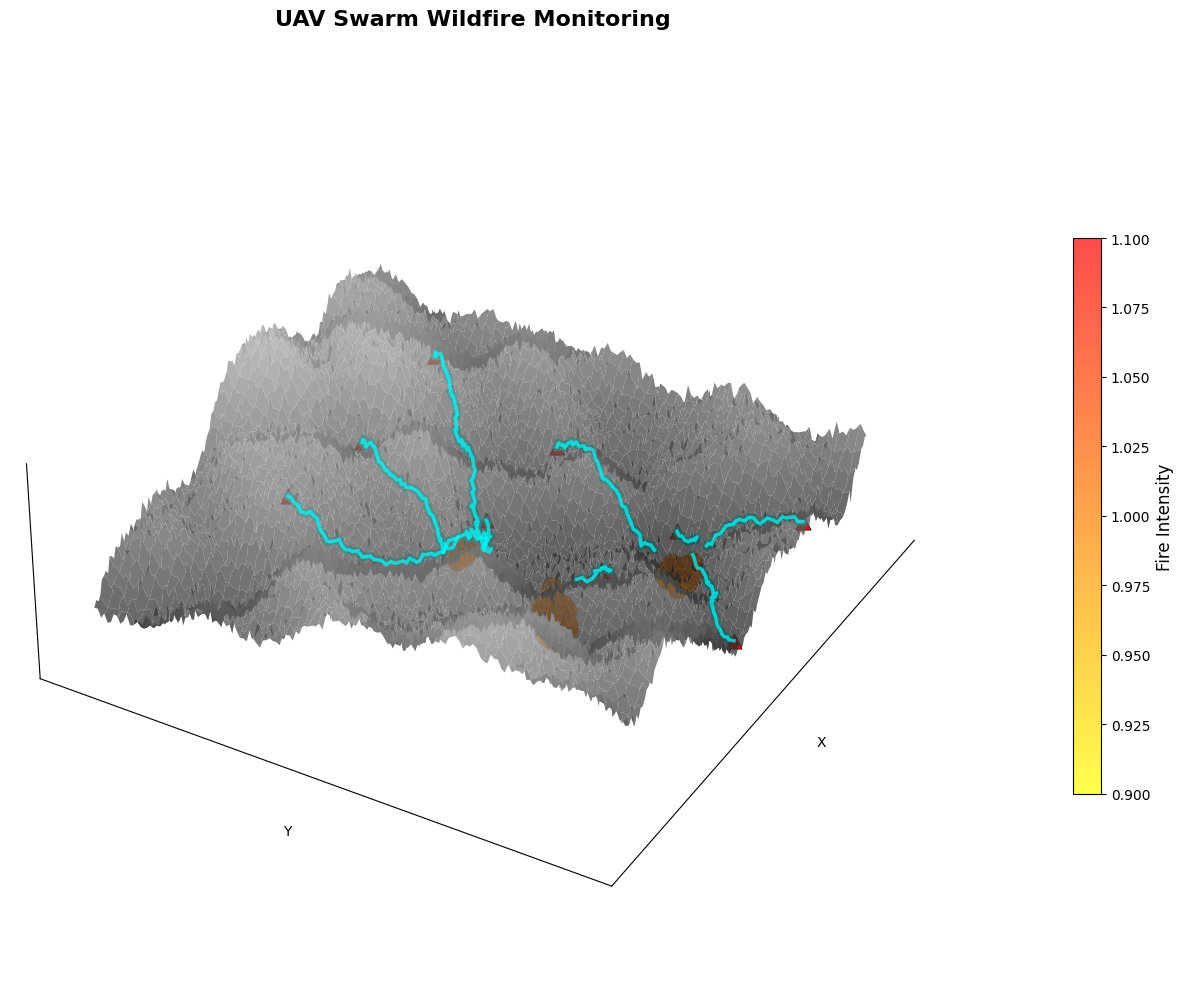

In [11]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple, Dict
import matplotlib as mpl
import heapq
from matplotlib.colors import LinearSegmentedColormap
import random

@dataclass
class UAV:
    position: np.ndarray  # [x, y, z]
    velocity: np.ndarray  # [vx, vy, vz]
    battery: float        # remaining battery percentage
    id: int              # unique identifier
    path: List[Tuple[int, int, float]] = None  # Path history or planned path [(x,y,z),...]
    
    def __post_init__(self):
        if self.path is None:
            self.path = [(self.position[0], self.position[1], self.position[2])]

class FireSimulation:
    def __init__(self, terrain_map, ignition_points=None):
        self.terrain = terrain_map
        self.fire_map = np.zeros(terrain_map.size, dtype=float)  # Fire intensity 0-1
        self.burned_map = np.zeros(terrain_map.size, dtype=bool)  # Track burned areas
        self.fire_age = np.zeros(terrain_map.size, dtype=int)     # Track fire age for visuals
        
        # Fire spread parameters
        self.base_spread_prob = 0.2       # Base probability of fire spreading
        self.elevation_factor = 0.015     # How much elevation affects spread (uphill = faster)
        self.wind_direction = [1, 1]      # Wind direction vector [x, y]
        self.wind_strength = 0.1          # Wind strength factor
        
        # Initialize fire if ignition points provided
        if ignition_points:
            for x, y in ignition_points:
                self.start_fire(x, y)
        
    def start_fire(self, x, y, radius=3):
        """Start a fire at given coordinates with specified radius"""
        for dx in range(-radius, radius+1):
            for dy in range(-radius, radius+1):
                if dx*dx + dy*dy <= radius*radius:  # Circular ignition
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.terrain.size[0] and 0 <= ny < self.terrain.size[1]:
                        self.fire_map[ny, nx] = 1.0  # Max intensity at ignition
    
    def update(self):
        """Update fire spread based on terrain and conditions"""
        new_fire = np.copy(self.fire_map)
        
        # Locations where fire is currently active
        active_y, active_x = np.where((self.fire_map > 0) & (self.fire_map < 1))
        
        for y, x in zip(active_y, active_x):
            # Update fire intensity (increases over time)
            if not self.burned_map[y, x]:
                new_fire[y, x] = min(1.0, self.fire_map[y, x] + 0.1)
                if new_fire[y, x] >= 0.8:  # Fire burns out after reaching high intensity
                    self.burned_map[y, x] = True
            
            # Spread to neighbors
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (1,1), (-1,1), (1,-1)]:
                nx, ny = x + dx, y + dy
                
                # Check boundaries
                if not (0 <= nx < self.terrain.size[0] and 0 <= ny < self.terrain.size[1]):
                    continue
                
                # Skip if already burning at high intensity or burned
                if self.fire_map[ny, nx] > 0.5 or self.burned_map[ny, nx]:
                    continue
                
                # Calculate spread probability based on terrain and conditions
                
                # 1. Elevation factor - fire spreads faster uphill
                elev_diff = self.terrain.get_elevation(nx, ny) - self.terrain.get_elevation(x, y)
                elev_factor = 1.0 + max(0, elev_diff * self.elevation_factor)
                
                # 2. Wind factor - fire spreads faster in wind direction
                wind_alignment = (dx * self.wind_direction[0] + dy * self.wind_direction[1])
                wind_factor = 1.0 + max(0, wind_alignment * self.wind_strength)
                
                # 3. Distance factor - diagonal spread is slower
                dist_factor = 1.0 if dx*dy == 0 else 0.7  # Diagonal = slower
                
                # Combined spread probability
                spread_prob = self.base_spread_prob * elev_factor * wind_factor * dist_factor
                
                # Apply spread
                if np.random.random() < spread_prob:
                    new_fire[ny, nx] = max(new_fire[ny, nx], 0.1)  # Start with low intensity
        
        # Age existing fires that are at max intensity
        self.fire_age[self.burned_map] += 1
        
        # Extinguish old fires (completely burned out)
        extinguish_mask = self.fire_age > 10
        new_fire[extinguish_mask] *= 0.8  # Gradually reduce intensity of old fires
        
        self.fire_map = new_fire

class TerrainMap:
    def __init__(self, size: Tuple[int, int], resolution: float = 1.0):
        self.size = size
        self.resolution = resolution
        self.elevation = np.zeros(size)
        
    def generate_sample_terrain(self, seed=None):
        """Generate a more interesting terrain with hills and valleys"""
        if seed is not None:
            np.random.seed(seed)
            
        # Create base grid
        x = np.linspace(0, 8, self.size[0])
        y = np.linspace(0, 8, self.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Combine multiple sinusoidal components for more natural-looking terrain
        self.elevation = (
            70 * np.sin(X/2) * np.cos(Y/2) +
            30 * np.sin(X*2) * np.cos(Y*2) +
            15 * np.sin(X*4+2) * np.cos(Y*3+1)
        )
        
        # Add some random noise for texture
        self.elevation += np.random.normal(0, 5, self.elevation.shape)
        
        # Ensure we have positive elevations only
        self.elevation -= np.min(self.elevation)
        
    def get_elevation(self, x: int, y: int) -> float:
        """Get elevation at specific coordinates"""
        if 0 <= x < self.size[0] and 0 <= y < self.size[1]:
            return self.elevation[y, x]
        return 0.0

class PathFinder:
    """A* path finding algorithm implementation"""
    def __init__(self, terrain, fire_sim=None):
        self.terrain = terrain
        self.fire_sim = fire_sim
        
    def find_path(self, start, goal, avoid_fire=True):
        """
        Find path from start to goal using A* algorithm
        
        Args:
            start: (x, y) starting coordinates
            goal: (x, y) goal coordinates
            avoid_fire: Whether to consider fire in pathfinding
            
        Returns:
            List of (x, y, z) coordinates for the path
        """
        # Initialize open and closed sets
        open_set = []
        closed_set = set()
        
        # Start node with cost = 0, f_score = heuristic distance to goal
        start_node = (0, 0, start, None)  # (f_score, g_score, (x,y), parent)
        heapq.heappush(open_set, start_node)
        
        # Map to store most efficient previous step for each node
        came_from = {}
        
        # Cost from start to current node
        g_score = {start: 0}
        
        while open_set:
            # Get node with lowest f_score
            current_f, current_g, current, _ = heapq.heappop(open_set)
            
            # Check if we've reached the goal
            if current == goal:
                # Reconstruct path
                path = []
                while current in came_from:
                    x, y = current
                    z = self.terrain.get_elevation(x, y) + 15  # Safe height above terrain
                    path.append((x, y, z))
                    current = came_from[current]
                    
                # Add start point
                x, y = start
                z = self.terrain.get_elevation(x, y) + 15
                path.append((x, y, z))
                
                # Reverse path (it's built backwards)
                return path[::-1]
            
            # Add to closed set (already evaluated)
            if current in closed_set:
                continue
                
            closed_set.add(current)
            
            # Get neighbors
            x, y = current
            neighbors = []
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue  # Skip self
                        
                    nx, ny = x + dx, y + dy
                    
                    # Check boundaries
                    if not (0 <= nx < self.terrain.size[0] and 0 <= ny < self.terrain.size[1]):
                        continue
                        
                    neighbors.append((nx, ny))
            
            # Evaluate neighbors
            for neighbor in neighbors:
                if neighbor in closed_set:
                    continue
                
                # Calculate distance (cost) to neighbor
                nx, ny = neighbor
                
                # Base movement cost (Euclidean distance)
                if abs(nx - x) == 1 and abs(ny - y) == 1:
                    move_cost = 1.414  # Diagonal movement cost (√2)
                else:
                    move_cost = 1.0
                
                # Elevation cost (more costly to climb steep slopes)
                elev_current = self.terrain.get_elevation(x, y)
                elev_next = self.terrain.get_elevation(nx, ny)
                elev_diff = abs(elev_next - elev_current)
                elev_cost = elev_diff * 0.1  # Penalty for elevation changes
                
                # Fire avoidance
                fire_cost = 0
                if avoid_fire and self.fire_sim:
                    # High cost to enter fire cells, progressive cost for proximity
                    fire_intensity = self.fire_sim.fire_map[ny, nx]
                    if fire_intensity > 0:
                        fire_cost = 1000 * fire_intensity  # Extremely high cost for active fires
                    
                    # Also avoid proximity to fire
                    for fdx, fdy in [(i, j) for i in range(-2, 3) for j in range(-2, 3)]:
                        fx, fy = nx + fdx, ny + fdy
                        if 0 <= fx < self.terrain.size[0] and 0 <= fy < self.terrain.size[1]:
                            nearby_fire = self.fire_sim.fire_map[fy, fx]
                            # Diminishing cost with distance
                            dist = max(1, abs(fdx) + abs(fdy))
                            fire_cost += (nearby_fire * 50) / dist
                
                # Total neighbor cost
                tentative_g = g_score.get(current, float('inf')) + move_cost + elev_cost + fire_cost
                
                # Check if this path is better than any previous one
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    # This is the best path so far to this neighbor
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    
                    # f_score = g_score + heuristic
                    h_score = ((neighbor[0] - goal[0]) ** 2 + (neighbor[1] - goal[1]) ** 2) ** 0.5
                    f_score = tentative_g + h_score
                    
                    heapq.heappush(open_set, (f_score, tentative_g, neighbor, current))
        
        # No path found
        return []

class SwarmSimulation:
    def __init__(self, num_uavs: int, terrain: TerrainMap, fire_sim=None):
        self.terrain = terrain
        self.uavs = []
        self.fire_sim = fire_sim
        self.path_finder = PathFinder(terrain, fire_sim)
        self.initialize_swarm(num_uavs)
        
    def initialize_swarm(self, num_uavs: int):
        """Initialize UAV swarm with strategic positions"""
        # Place UAVs in a more structured formation
        spacing = self.terrain.size[0] / (np.sqrt(num_uavs) + 1)
        
        uav_count = 0
        for i in range(1, int(np.sqrt(num_uavs)) + 2):
            for j in range(1, int(np.sqrt(num_uavs)) + 2):
                if uav_count < num_uavs:
                    x = int(i * spacing)
                    y = int(j * spacing)
                    
                    # Ensure within terrain bounds
                    x = min(x, self.terrain.size[0] - 1)
                    y = min(y, self.terrain.size[1] - 1)
                    
                    z = self.terrain.get_elevation(x, y) + 15  # 15m above terrain
                    
                    self.uavs.append(UAV(
                        position=np.array([x, y, z]),
                        velocity=np.zeros(3),
                        battery=100.0,
                        id=uav_count
                    ))
                    
                    uav_count += 1
                    
    def plan_paths_for_fire_monitoring(self):
        """Plan paths for UAVs to optimally monitor fires"""
        if not self.fire_sim:
            return
        
        # Find fire locations (cells with fire intensity > 0.3)
        fire_y, fire_x = np.where(self.fire_sim.fire_map > 0.3)
        if len(fire_y) == 0:
            return  # No significant fires to monitor
            
        fire_locations = list(zip(fire_x, fire_y))
        
        # Assign nearest fire to each UAV
        for uav in self.uavs:
            if not fire_locations:
                continue  # No more fires to assign
                
            # Find closest fire to this UAV
            uav_pos = (int(uav.position[0]), int(uav.position[1]))
            min_dist = float('inf')
            closest_fire = None
            
            for fire_pos in fire_locations:
                dist = ((uav_pos[0] - fire_pos[0])**2 + (uav_pos[1] - fire_pos[1])**2)**0.5
                if dist < min_dist:
                    min_dist = dist
                    closest_fire = fire_pos
            
            # Plan path to a safe monitoring position near the fire
            if closest_fire:
                # Find a safe position near fire (not in fire, slightly higher elevation if possible)
                safe_positions = []
                
                # Check positions in a ring around the fire
                for dx, dy in [(i, j) for i in range(-3, 4) for j in range(-3, 4) 
                              if 2 <= abs(i) + abs(j) <= 5]:  # Ring radius 2-5
                    safe_x, safe_y = closest_fire[0] + dx, closest_fire[1] + dy
                    
                    # Check bounds
                    if 0 <= safe_x < self.terrain.size[0] and 0 <= safe_y < self.terrain.size[1]:
                        # Check if position is safe (no fire)
                        if self.fire_sim.fire_map[safe_y, safe_x] < 0.1:
                            safe_positions.append((safe_x, safe_y))
                
                # Choose safe position with highest elevation (better visibility)
                if safe_positions:
                    best_pos = max(safe_positions, 
                                  key=lambda pos: self.terrain.get_elevation(pos[0], pos[1]))
                    
                    # Find path to safe position
                    path = self.path_finder.find_path(uav_pos, best_pos, avoid_fire=True)
                    if path:
                        # Convert path to 3D coordinates and assign to UAV
                        uav.path = path
                        
                        # Update UAV position to first point on path
                        if path:
                            uav.position = np.array(path[0])
                
                # Remove this fire from available targets
                fire_locations.remove(closest_fire)
    
    def update(self, dt: float = 0.1):
        """Update simulation by one timestep"""
        # Update fires
        if self.fire_sim:
            self.fire_sim.update()
        
        # Plan new paths if needed
        if np.random.random() < 0.1:  # Occasionally replan paths
            self.plan_paths_for_fire_monitoring()
        
        # Update UAVs
        for uav in self.uavs:
            # Simple update - just decrease battery
            uav.battery -= dt
            
            # Here you'll later add your ACO/BCO logic for path planning
            pass
    
    def visualize_with_fire_and_paths(self, save_path=None):
        """Visualize terrain, fire, UAVs, and their flight paths"""
        plt.style.use('default')
        fig = plt.figure(figsize=(14, 10), facecolor='white')
        ax = fig.add_subplot(111, projection='3d', facecolor='white')
        
        # Plot terrain in darker grayscale
        x = np.arange(self.terrain.size[0])
        y = np.arange(self.terrain.size[1])
        X, Y = np.meshgrid(x, y)
        
        # Custom darker grayscale colormap
        dark_gray_cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'dark_gray', [(0, '#222222'), (1, '#AAAAAA')])
        
        terrain_surface = ax.plot_surface(X, Y, self.terrain.elevation,
                                        cmap=dark_gray_cmap, 
                                        antialiased=True, 
                                        shade=True,
                                        alpha=0.8)
        
        # Plot fire if available
        if self.fire_sim is not None:
            fire_mask = self.fire_sim.fire_map > 0.1
            if np.any(fire_mask):
                fire_y, fire_x = np.where(fire_mask)
                fire_z = np.array([self.terrain.get_elevation(x, y) for x, y in zip(fire_x, fire_y)])
                fire_intensity = self.fire_sim.fire_map[fire_mask]
                
                # Use size and color based on intensity
                fire_sizes = 50 + 150 * fire_intensity
                
                # Create custom fire colormap (yellow to red)
                fire_cmap = LinearSegmentedColormap.from_list(
                    'fire', [(1.0, 1.0, 0.0, 0.8),  # Yellow (transparent)
                             (1.0, 0.5, 0.0, 0.9),  # Orange
                             (1.0, 0.0, 0.0, 1.0)]) # Red
                
                # Scatter plot with varying sizes and colors for fires
                sc = ax.scatter(fire_x, fire_y, fire_z + 0.5,  # Slight offset for visibility
                             s=fire_sizes, 
                             c=fire_intensity,
                             cmap=fire_cmap,
                             marker='o',
                             alpha=0.7,
                             zorder=10)
        
        # Plot UAV paths
        for uav in self.uavs:
            if uav.path and len(uav.path) > 1:
                # Extract path coordinates
                path_x = [p[0] for p in uav.path]
                path_y = [p[1] for p in uav.path]
                path_z = [p[2] for p in uav.path]
                
                # Plot planned path
                ax.plot(path_x, path_y, path_z, 
                      color='cyan', alpha=0.7, linewidth=2.5,
                      zorder=50)
                
                # Add small markers at waypoints
                ax.scatter(path_x, path_y, path_z,
                         color='cyan', s=30, marker='o',
                         alpha=0.7, zorder=50)
            
            # Plot the UAV
            ax.scatter(
                uav.position[0], uav.position[1], uav.position[2],
                color='#FF0000', 
                marker='^', 
                s=120,
                edgecolor='black', 
                linewidth=0.5,
                zorder=100
            )
        
        # Same styling as before
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        ax.set_xlabel('X', color='black', labelpad=10)
        ax.set_ylabel('Y', color='black', labelpad=10)
        ax.set_zlabel('Elevation', color='black', labelpad=10)
        
        plt.title('UAV Swarm Wildfire Monitoring', color='black', fontsize=16, pad=20, fontweight='bold')
        
        # Show legend for fire intensity
        if self.fire_sim is not None and np.any(fire_mask):
            cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
            cbar.set_label('Fire Intensity', fontsize=12)
        
        # Adjust view for better perspective
        ax.view_init(elev=35, azim=30)
        ax.set_box_aspect([1, 1, 0.4])
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Visualization saved to {save_path}")
            
        plt.tight_layout()
        plt.show()

# Example usage
def main():
    # Create terrain
    terrain = TerrainMap(size=(150, 150))
    terrain.generate_sample_terrain(seed=42)
    
    # Create fire simulation
    fire_sim = FireSimulation(terrain)
    
    # Start fires at random locations
    for _ in range(3):
        x = np.random.randint(30, terrain.size[0]-30)
        y = np.random.randint(30, terrain.size[1]-30)
        fire_sim.start_fire(x, y, radius=np.random.randint(2, 5))
    
    # Create simulation with UAVs
    sim = SwarmSimulation(num_uavs=9, terrain=terrain, fire_sim=fire_sim)
    
    # Let fire spread
    for _ in range(15):
        fire_sim.update()
    
    # Plan paths for UAVs
    sim.plan_paths_for_fire_monitoring()
    
    # Visualize
    sim.visualize_with_fire_and_paths(save_path="uav_swarm_fire_monitoring.png")

if __name__ == "__main__":
    main()